In [5]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
from matplotlib import cm
from pyearth import Earth

## 7.2

Friedman 1991 introduced several benchmark data sets create by simulation. One of these simulations used the following nonlinear equation to create data

$$
y = 10\sin(\pi x_{1}x_{2}) + 20(x_{3} - 0.5)^{2} + 10x_{4} + 5x_{5} + N(0, \sigma^{2})
$$

where the $x_{i} \sim U[0,1]$ (there are also 5 other non-informative variables also created in the simulation). 
    
**(a) Which models appear to give the best performance? Does MARS select the informative predictors (those named X1–X5)?**





In [6]:
from sklearn.model_selection import train_test_split

def split_data(df, target, val_size=0.2, test_size=0.2, drop_columns=[]):
    x={}
    y={}
    
    train_val, test = train_test_split(df, test_size=test_size)
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size))
    ds = {}
    x["train"] = train.drop(columns=[target]+drop_columns)
    x["val"] = val.drop(columns=[target]+drop_columns)
    x["train_val"] = train_val.drop(columns=[target]+drop_columns)
    x["test"] = test.drop(columns=[target]+drop_columns)
    y["train"] = train[target]
    y["val"] = val[target]
    y["train_val"] = train_val[target]
    y["test"] = test[target]
    
    return x,y

In [7]:
# MARS
# SVR
# KNN
# Creating synthetic data
np.random.seed(seed=12345)
df = pd.DataFrame(np.random.uniform(size=(200,10)), columns = [f"x{i+1}" for i in range(10)])
df["error"] = np.random.normal(size=200)
df["target"] = (
    10*np.sin(np.pi*df["x1"]*df["x2"]) +
    20*(df["x3"]-0.5)**2 + 
    10*df["x4"] + 
    5*df["x5"] +
    df["error"])
X = df.drop(columns=["target", "error"])
y = df["target"]

In [8]:
x, y=split_data(df, "target", drop_columns=["error"])

In [9]:
mars = Earth(feature_importance_type='gcv')
mars.fit(x["train_val"], y["train_val"])
mars.score(x["test"], y["test"])

/home/roger/anaconda3/envs/coursera/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/roger/anaconda3/envs/coursera/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


0.8855066186627008

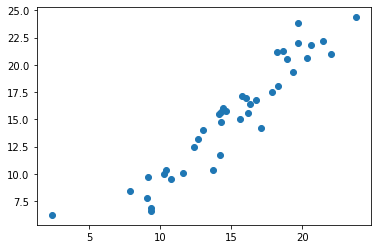

In [10]:
plt.scatter(mars.predict(x["test"]), y["test"])
plt.show()

In [11]:
print(mars.summary())

# x4
# x3
# x1
# x5
# x2

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      8.79555      
x4              No      9.64184      
h(x1-0.613266)  Yes     None         
h(0.613266-x1)  Yes     None         
h(x2-0.573879)  Yes     None         
h(0.573879-x2)  Yes     None         
h(x3-0.49255)   No      10.3327      
h(0.49255-x3)   No      10.502       
x5              Yes     None         
h(x1-0.195795)  No      4.81044      
h(0.195795-x1)  No      -26.9557     
h(x5-0.670874)  Yes     None         
h(0.670874-x5)  No      -5.75468     
h(x5-0.888561)  No      25.2934      
h(0.888561-x5)  Yes     None         
x9              Yes     None         
h(x4-0.803585)  Yes     None         
h(0.803585-x4)  Yes     None         
h(x2-0.521645)  Yes     None         
h(0.521645-x2)  No      -12.4131     
h(x5-0.291053)  Yes     None         
h(0.291053-x5)  Yes     None         
h(x5-0.324602)  Yes     None         


In [12]:
print(mars.summary_feature_importances(sort_by="gcv"))

        gcv
x4      0.43   
x1      0.27   
x2      0.20   
x3      0.10   
x10     0.00   
x9      0.00   
x8      0.00   
x7      0.00   
x6      0.00   
x5      0.00   



In [13]:
# SVR
scores={}

for epsilon in np.geomspace(0.01, 20, num=10):
    for cost in np.geomspace(0.01, 20, num=10):
        svr = SVR(kernel="rbf", C=cost, epsilon=epsilon)
        svr.fit(X=x["train"], y=y["train"])
        scores[(epsilon, cost)] = svr.score(X=x['val'], y=y['val'])
        
best_epsilon, best_cost = max(scores, key=scores.get)

In [14]:
e, c, r2 = [], [], []
for a, b in scores:
    e.append(a)
    c.append(b)
    r2.append(scores[(a, b)])

#Normalising scores between 0 to 1.
r3 = [(min(r2)-i)/(max(r2)-min(r2))+1 for i in r2]

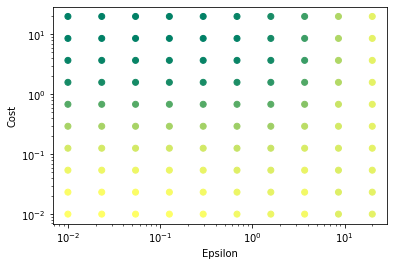

In [15]:
plt.scatter(x=e, y=c, color=cm.summer(r3))
plt.xlabel('Epsilon')
plt.ylabel('Cost')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [16]:
svr=SVR(kernel="rbf", C=best_cost, epsilon=best_epsilon)
svr.fit(X=x["train_val"], y=y["train_val"])
svr.score(X=x['test'], y=y['test'])

0.8061249317423191

In [17]:
#KNN
n_neighbors = 5
weights="uniform"


knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
knn.fit(X=x["train_val"], y=y["train_val"])
knn.score(X=x["test"], y=y["test"])

0.4410992753709

In [18]:
scores={}

for weights in ["uniform", "distance"]:
    for n_neighbors in range(1, 21):
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X=x["train"], y=y["train"])
        scores[(weights, n_neighbors)] = knn.score(X=x["val"], y=y["val"])
        
best_weight, best_n = max(scores, key=scores.get)
knn = KNeighborsRegressor(n_neighbors=best_n, weights=best_weight)
knn.fit(X=x["train_val"], y=y["train_val"])
knn.score(X=x["test"], y=y["test"])

0.5656449413061868

In [19]:
best_weight, best_n

('distance', 11)

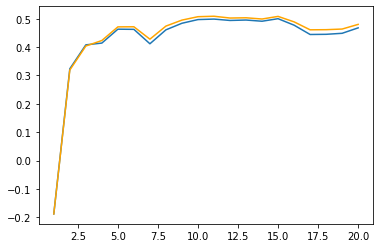

In [19]:
plt.plot(range(1, 21), [scores[("uniform", i)] for i in range(1, 21)])
plt.plot(range(1, 21), [scores[("distance", i)] for i in range(1, 21)], color="orange")